In [23]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn import Linear, Softmax, Sigmoid, Module
from scipy.optimize import minimize
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.connectors import TorchConnector
import qiskit
import qiskit_machine_learning
print(qiskit.version.get_version_info())
print(qiskit_machine_learning.version.get_version_info())

1.2.4
0.8.0


In [24]:
# Creating Circuit

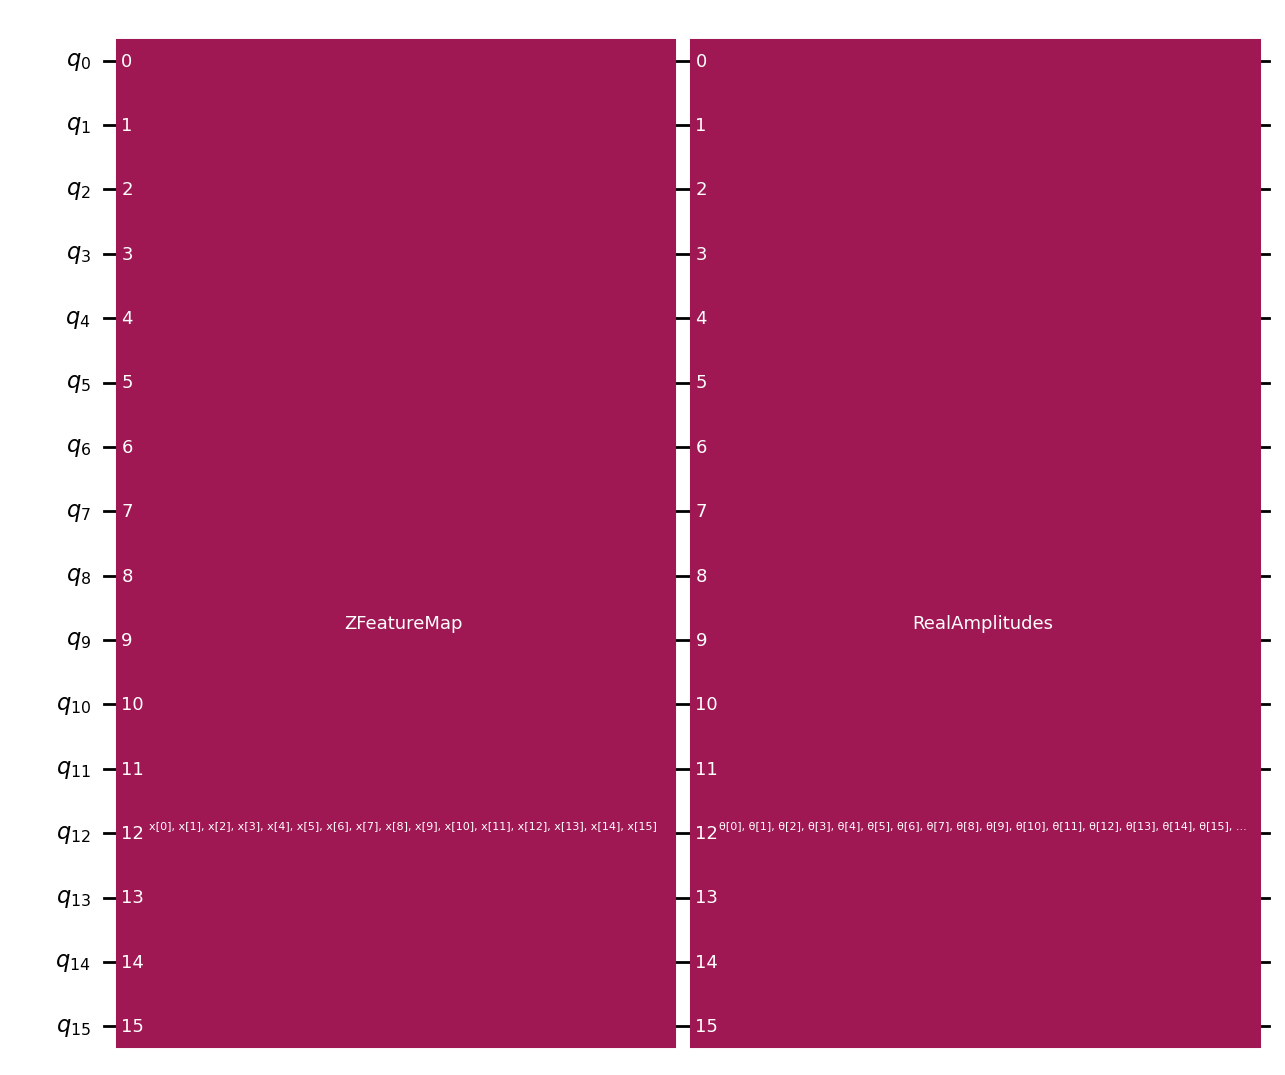

In [25]:
# Ansatz Instantiation Method
from qiskit import ClassicalRegister, QuantumRegister
feature_map = ZFeatureMap(16)
def create_QCNN():
    q_reg = QuantumRegister(16, "q_reg")
    ansatz = QuantumCircuit(q_reg, name="Ansatz")

    ansatz = qiskit.circuit.library.RealAmplitudes(16, reps=3, insert_barriers=True)

    # Combining the feature map and ansatz
    circuit = QNNCircuit(16)
    circuit.feature_map = feature_map
    circuit.ansatz = ansatz
    return circuit

# Visual
display(create_QCNN().draw("mpl"))

In [26]:
# Creating/Formatting Data

In [27]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis]/(255.0/np.pi), x_test[..., np.newaxis]/(255.0/np.pi)
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [28]:
# Filter Values
a = 3
b = 4
c = 5
d = 6
def filter_abcd(x, y):
    keep = (y == a) | (y == b) | (y == c) | (y == d)
    x, y = x[keep], y[keep]
    return x,y

In [29]:
# Filtering using previous method.
x_train, y_train = filter_abcd(x_train, y_train)
x_test, y_test = filter_abcd(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 23312
Number of filtered test examples: 3842


6


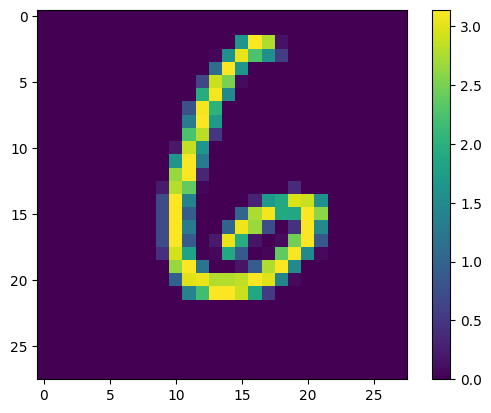

In [30]:
# Displaying Sample Image
img = 13
print(y_train[img])
plt.imshow(x_train[img, :, :, 0])
plt.colorbar()

In [31]:
# Resizing (Quantum Computing Simulation Limit)
x_train_small = tf.image.resize(x_train, (4,4), method = 'area').numpy()
x_test_small = tf.image.resize(x_test, (4,4), method = 'area').numpy()

6


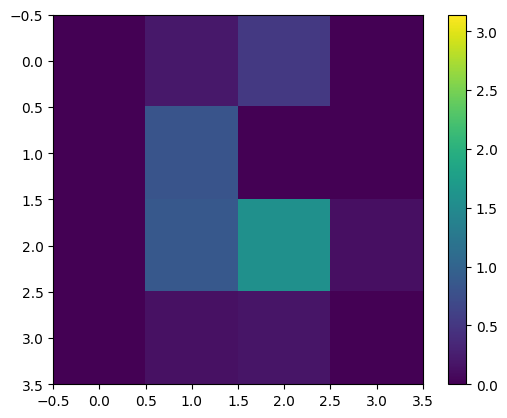

In [32]:
# Displaying Image Sample After Resizing
img = 13
print(y_train[img])
plt.imshow(x_train_small[img,:,:,0], vmin=0, vmax=np.pi)
plt.colorbar()

In [33]:
# Formatting Helper Methods
def format_data(a,b):
    x_reshaped = []
    x1_reshaped = []

    for g in a:
        x_reshaped.append(g.reshape(1,16))

    for g in b:
        x1_reshaped.append(g.reshape(1,16))

    final_x = []
    final_x1 = []

    for entry in x_reshaped:
        final_x.append(entry[0])

    for entry in x1_reshaped:
        final_x1.append(entry[0])
    return final_x, final_x1

def format_labels(y):
    y_temp = []
    for entry in y:
        if entry == a:
            y_temp.append(0)
        elif entry == b:
            y_temp.append(1)
        elif entry == c:
            y_temp.append(2)
        elif entry == d:
            y_temp.append(3)
    return y_temp

In [34]:
x,x1 = format_data(x_train_small, x_test_small)

# Easier to work with names
y = y_train
y1 = y_test

# Setting labels to 0,1,2,3 for easy reference later
y = format_labels(y)
y1 = format_labels(y1)

# Converting to nparray
x = np.asarray(x)
y = np.asarray(y)
x1 = np.asarray(x1)
y1 = np.asarray(y1)

# Limiting training dataset to lower training time.
x = x[0:128]
y = y[0:128]
x1 = x1[0:128]
y1 = y1[0:128]
print(x)
print(y)

[[0.         0.19058241 0.5850729  ... 1.2083628  0.15663964 0.        ]
 [0.0359542  0.         0.04701703 ... 0.         0.54685587 0.        ]
 [0.         0.26902792 0.86968946 ... 1.3765682  0.4684103  0.        ]
 ...
 [0.         0.21999948 1.2091172  ... 0.9302835  0.07215983 0.        ]
 [0.         0.00553142 0.68262696 ... 0.99364346 0.57375866 0.        ]
 [0.         0.         0.17826243 ... 0.16342819 0.2768222  0.        ]]
[2 1 0 1 0 2 0 3 3 1 1 0 0 3 2 3 3 0 2 0 0 1 1 1 1 3 1 2 3 3 0 3 0 1 3 1 3
 0 2 3 0 0 1 3 1 3 0 1 2 0 0 2 1 1 2 3 0 1 3 3 0 1 1 3 1 2 2 0 0 2 3 2 1 0
 0 3 0 0 1 3 2 3 1 0 0 2 1 3 2 3 0 2 0 0 0 3 1 2 3 2 1 1 2 3 1 2 0 0 2 3 2
 1 0 1 1 1 0 3 3 2 3 1 2 0 3 0 2 1]


In [35]:
# Additional Helper Functions
def count(y):
    counta = 0
    countb = 0
    countc = 0
    countd = 0
    for i in range(len(y)):
        if y[i] == 0:
            counta+=1
        elif y[i] == 1:
            countb+=1
        elif y[i] == 2:
            countc+=1
        elif y[i] == 3:
            countd+=1
    return(counta, countb, countc, countd)

def balance_lists(x, y, max_count):
    """Balances two lists x and y based on the values in y (0 or 1)."""
    
    x_balanced = []
    y_balanced = []
    count0 = 0
    count1 = 0
    count2 = 0
    count3 = 0

    for i in range(len(y)):
        if y[i] == 0:
            if count0 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count0 += 1
        elif y[i] == 1:
            if count1 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count1 += 1
        elif y[i] == 2:
            if count2 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count2 += 1
        elif y[i] == 3:
            if count3 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count3 += 1
    return x_balanced, y_balanced

def shuffle(arr1, arr2):
    assert len(arr1) == len(arr2)
    p = np.random.permutation(len(arr1))
    return arr1[p], arr2[p]

In [36]:
# Further Data Cleaning Using Helper Functions
nums = count(y)
print("original:", nums)
max_count = min(nums)
print("max_count =", max_count)
x,y = balance_lists(x, y, max_count)

print("balanced:", count(y))

# Converting to nparray
x = np.asarray(x)
y = np.asarray(y)
x1 = np.asarray(x1)
y1 = np.asarray(y1)
objective_func_vals = []

x,y = shuffle(x,y)
print("shuffled:", count(y))

print("final:", x)
print(y)

original: (36, 34, 26, 32)
max_count = 26
balanced: (26, 26, 26, 26)
shuffled: (26, 26, 26, 26)
final: [[0.         0.         0.29894787 ... 0.2883879  0.09101693 0.        ]
 [0.         0.19058241 0.5850729  ... 1.2083628  0.15663964 0.        ]
 [0.13275397 0.61222714 0.5403188  ... 0.66427267 0.9033807  0.00553142]
 ...
 [0.00980569 0.49078742 0.7017355  ... 1.6810473  0.8636551  0.        ]
 [0.         0.2886393  0.25670797 ... 0.         0.6735756  0.        ]
 [0.         0.17951958 0.00201142 ... 0.28637645 0.13929111 0.        ]]
[1 2 2 3 0 2 1 0 2 2 2 3 3 2 1 1 0 1 1 1 3 1 1 0 3 2 1 0 0 3 1 2 3 2 0 0 0
 1 3 1 3 0 1 0 2 1 2 2 2 1 2 1 3 2 2 0 1 3 3 1 2 0 3 0 3 2 1 3 3 0 0 0 1 2
 3 3 0 0 3 0 2 1 2 0 3 1 0 3 2 1 3 2 2 3 3 3 0 3 0 2 0 0 1 1]


In [37]:
# Tensor for Pytorch
X = torch.tensor(x, dtype=torch.float32).to("cuda")
Y = torch.tensor(y, dtype=torch.long).to("cuda")
X1 = torch.tensor(x1, dtype=torch.float32).to("cuda")
Y1 = torch.tensor(y1, dtype=torch.long).to("cuda")

In [38]:
# One-Hot Encoding for Final Processing
num_classes = 4
Y = (torch.nn.functional.one_hot(Y, num_classes=num_classes).float())
Y1 = (torch.nn.functional.one_hot(Y1, num_classes=num_classes).float())

In [39]:
print(X,Y,X1,Y1)

tensor([[0.0000, 0.0000, 0.2989,  ..., 0.2884, 0.0910, 0.0000],
        [0.0000, 0.1906, 0.5851,  ..., 1.2084, 0.1566, 0.0000],
        [0.1328, 0.6122, 0.5403,  ..., 0.6643, 0.9034, 0.0055],
        ...,
        [0.0098, 0.4908, 0.7017,  ..., 1.6810, 0.8637, 0.0000],
        [0.0000, 0.2886, 0.2567,  ..., 0.0000, 0.6736, 0.0000],
        [0.0000, 0.1795, 0.0020,  ..., 0.2864, 0.1393, 0.0000]],
       device='cuda:0') tensor([[0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
      

In [40]:
# Training

In [41]:
# Pytorch Circuit Module
import torch.nn as nn
class Model(Module): # Simplified
    def __init__(self, qnn_module):
        super().__init__()
        self.qnn_module = qnn_module
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.qnn_module(x)
        x = self.softmax(x)
        return x

In [42]:
from qiskit_aer.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.utils import algorithm_globals

# Reproducable seeds
num_qubits = 16
algorithm_globals.random_seed = 65
seed = 90

# Creating GPU compatible Estimator primitive
sampler = Estimator()
sampler.set_options(device='GPU')
sampler.set_options(method="statevector")
sampler.set_options(seed = seed)

# Setting observables on 15th and 16th qubits.
observable_z10 = SparsePauliOp.from_sparse_list([("Z", [9], 1)], num_qubits=num_qubits)
observable_z9 = SparsePauliOp.from_sparse_list([("Z", [8], 1)], num_qubits=num_qubits)
observable_z8 = SparsePauliOp.from_sparse_list([("Z", [7], 1)], num_qubits=num_qubits)
observable_z7 = SparsePauliOp.from_sparse_list([("Z", [6], 1)], num_qubits=num_qubits)
observables = [observable_z7, observable_z8, observable_z9, observable_z10]

# Instantiating underlying EstimatorQNN
estimator = EstimatorQNN(
    estimator = sampler,
    circuit = create_QCNN(),
    observables = observables,
    input_gradients = True,
)

# Initial Forward Weights
weights = algorithm_globals.random.random(estimator.num_weights)

# Checking Data Forward Result
estimator.forward(input_data = x1[:30], weights = weights)

/tmp/ipykernel_31370/1357640316.py:24: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  estimator = EstimatorQNN(
/tmp/ipykernel_31370/1357640316.py:24: UserWarning: No number of qubits was not specified (None) and was retrieved from `circuit` (16). If `circuit` is transpiled, this may cause unstable behaviour.
  estimator = EstimatorQNN(


array([[ 0.14648438,  0.23046875,  0.04492188,  0.203125  ],
       [ 0.1640625 ,  0.0546875 ,  0.24609375, -0.11328125],
       [-0.00585938,  0.19335938, -0.15429688,  0.09960938],
       [ 0.23242188,  0.1328125 ,  0.0546875 ,  0.2265625 ],
       [-0.09179688, -0.02539062, -0.19140625,  0.1640625 ],
       [-0.234375  , -0.09570312,  0.18945312,  0.35351562],
       [ 0.05078125,  0.22851562, -0.00976562,  0.11914062],
       [-0.17578125, -0.13867188, -0.2265625 , -0.13671875],
       [ 0.14257812,  0.16992188,  0.05664062,  0.3515625 ],
       [-0.15625   , -0.04492188, -0.16796875,  0.32421875],
       [ 0.03320312,  0.1953125 ,  0.00390625,  0.1640625 ],
       [ 0.16601562,  0.140625  ,  0.0390625 ,  0.2578125 ],
       [ 0.234375  ,  0.19921875,  0.27148438, -0.31445312],
       [ 0.10351562,  0.140625  ,  0.1015625 ,  0.03710938],
       [-0.24023438,  0.0078125 ,  0.0625    ,  0.16210938],
       [ 0.28125   ,  0.11328125,  0.13671875,  0.296875  ],
       [-0.0234375 ,  0.

In [43]:
# Wrapping estimator with initial weights under TorchConnecter, itself under Pytorch Module.
model = Model(TorchConnector(estimator, weights))
model.to("cuda")
next(model.parameters()).is_cuda

True

In [44]:
# We want to supply one-hot encoded labels.
from tensorflow.keras.losses import CategoricalCrossentropy
loss_func = CategoricalCrossentropy()

# Callback Helper Functions
def accuracy(output, Y):
    acc = 0
    for i in range(Y.size(dim=0)):
        val = output[i]
        if (torch.argmax(val) == torch.argmax(Y[i])):
            acc+=1
    return ((acc/(Y.size(dim=0)))*100)

def objective_function(weights):
    global X
    global Y
    if(i != 1 and i%333 == 0):
        indices = torch.randperm(X.size()[0])
        X=X[indices]
        Y=Y[indices]
        print(X,Y)
    # Referencing Global Variables
    global data
    # Local Variable
    total_loss = 0.0
    # Overiding with new data
    model = Model(TorchConnector(estimator, weights)).to("cuda")
    # Getting Output
    output = model(X)
    loss_output = output.detach().cpu().numpy()
    loss_Y = Y.detach().cpu().numpy()
    # Calculate Loss
    loss = loss_func(loss_output, loss_Y).numpy()
    # Append Checkpoint Data Points to Tracker
    val = f"Iteration: {i}; Accuracy: {accuracy(output, Y)}%; Loss: {loss}"
    data.append(val)
    total_loss += loss
    loss_list.append(total_loss)
    return total_loss

def callback(weights):
    # Iteration Tracking
    global i
    global weight_list
    # Printing Checkpoint Data Points in Tracker
    print("\n".join(data))
    # Plotting Loss Function
    plt.title("Loss value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Loss function value")
    plt.plot(range(len(loss_list)), loss_list)
    plt.show()
    # Printing Weights
    weight_list.append(weights)
    print(weights)
    # Iteration Counter
    i+=1
    # Clearing Previous Graph/Weights
    clear_output(wait=True)

In [45]:
# Training Function
def fit(weights=None, losslist=None, iter= 1000, fresh_start = False):
    global i
    global data
    global weight_list
    global loss_list
    if(fresh_start):
        loss_list = []
        data = []
        weight_list = []
        weights = algorithm_globals.random.random(estimator.num_weights)
        i = 1
    else:
        if 'data' not in globals(): data = []
        else: data = data
        if 'weight_list' not in globals():weight_list = []
        else: weight_list = weight_list
        if 'i' not in globals() and 'i' not in locals(): i = 1
        else: i = i
        if losslist is not None: losslist = losslist
        elif (('loss_list' not in globals() and 'loss_list' not in locals()) and losslist == None): loss_list = []
        elif 'loss_list' not in globals() and 'loss_list' not in locals(): loss_list = losslist
        else: loss_list = loss_list
        if weights is not None: weights = weights
        elif (('result' not in locals() and 'result' not in globals())) and weights == None:
            weights = algorithm_globals.random.random(estimator.num_weights)
        elif (len(weight_list)>0):
            weights = weight_list[-1]
        else:
            weights = result[0].x
            loss_list = result[2]
    
    result = minimize(
        fun=objective_function,
        callback = callback,
        x0=weights,
        method='COBYLA',
        options={'maxiter': iter},
    )
    return result, data, loss_list, weight_list

Iteration: 1; Accuracy: 28.846153846153843%; Loss: 12.012578010559082
Iteration: 2; Accuracy: 28.846153846153843%; Loss: 12.012578010559082
Iteration: 3; Accuracy: 28.846153846153843%; Loss: 12.012578010559082
Iteration: 4; Accuracy: 28.846153846153843%; Loss: 12.012578010559082
Iteration: 5; Accuracy: 23.076923076923077%; Loss: 12.00673770904541
Iteration: 6; Accuracy: 27.884615384615387%; Loss: 12.025541305541992
Iteration: 7; Accuracy: 23.076923076923077%; Loss: 12.023637771606445
Iteration: 8; Accuracy: 29.807692307692307%; Loss: 11.961709022521973
Iteration: 9; Accuracy: 24.03846153846154%; Loss: 12.039372444152832
Iteration: 10; Accuracy: 17.307692307692307%; Loss: 12.065215110778809
Iteration: 11; Accuracy: 20.192307692307693%; Loss: 12.158997535705566
Iteration: 12; Accuracy: 32.69230769230769%; Loss: 11.985200881958008
Iteration: 13; Accuracy: 34.61538461538461%; Loss: 11.955270767211914
Iteration: 14; Accuracy: 30.76923076923077%; Loss: 11.952436447143555
Iteration: 15; Accur

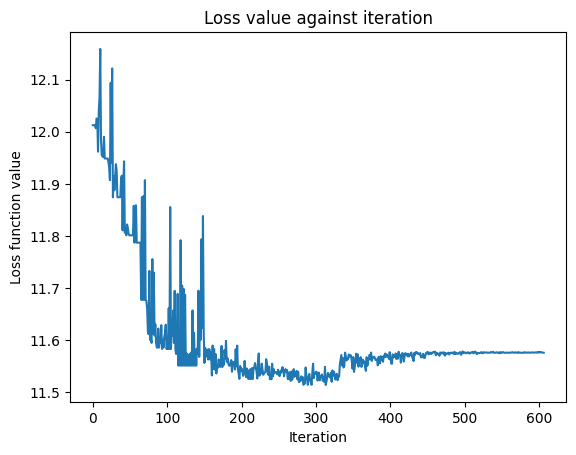

[ 0.240044    0.73216328  0.27598296  2.06048235  1.78551441  1.08700906
  2.04952138  0.21412117 -0.00237879  0.26378572  1.70178528  2.35648982
  1.91217956  1.36612792  0.48974295  1.3146189   0.32865085  0.30063759
  0.53551412  0.5773228   1.58889072  1.43232186  1.45457201 -0.12420792
  1.56267712 -0.06993223  1.67123725  0.08315604  0.06030377  0.15021302
  0.36345124  0.96842067  0.97812134  0.22516202  0.50007459  0.51868832
  0.84142375  0.34336012 -0.03791997  2.15942848 -0.06415418 -0.1082521
  1.02654619  0.4731944   1.43959428  1.86594119  1.10565102  0.14723819
  0.60293284  0.71791017  0.46089521  1.00460973  0.60785004  0.75231658
  0.6549851   1.18325567  0.04956248  0.08433978  0.95046512  0.46364089
  0.77700558  0.40113239  0.89513002  0.47144598]


In [46]:
# Call Training Function and Save as Result
result = fit(iter=1000, fresh_start=False)

In [47]:
savemodel = Model(TorchConnector(estimator, result[0].x))
print(next(model.parameters()).is_cuda)
torch.save(savemodel, "4Classes_RandCircuit")

True


In [48]:
evalmodel = torch.load("4Classes_RandCircuit", weights_only=False).to("cuda")
evalmodel.eval()
output0 = evalmodel(X)
output1 = evalmodel(X1)
print(f"Train Accuracy: {accuracy(output0, Y)}%")
print(f"Test Accuracy: {accuracy(output1, Y1)}%")

Train Accuracy: 41.34615384615385%
Test Accuracy: 38.28125%


In [49]:
def translate(array):
    arr = []
    for e in array:
        arr.append(torch.argmax(e))
    return arr
print(f"output 0: {translate(output0)}, \n Y:       {translate(Y)}, \n output 1: {translate(output1)}, \n Y1:       {translate(Y1)}")

output 0: [tensor(2, device='cuda:0'), tensor(0, device='cuda:0'), tensor(2, device='cuda:0'), tensor(3, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(3, device='cuda:0'), tensor(3, device='cuda:0'), tensor(2, device='cuda:0'), tensor(0, device='cuda:0'), tensor(3, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(3, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(2, device='cuda:0'), tensor(0, device='cuda:0'), tensor(2, device='cuda:0'), tensor(3, device='cuda:0'), tensor(3, device='cuda:0'), tensor(2, device='cuda:0'), tensor(3, device='cuda:0'), tensor(2, device='cuda:0'), tensor(0, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(3, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(2, device='cuda:0'), tensor(3, device='cuda:0'), tensor(3,

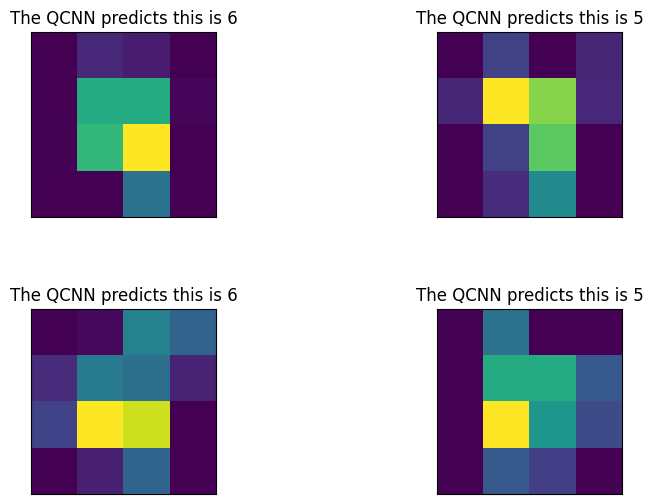

In [50]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(X1.detach().cpu().numpy()[i].reshape(4, 4), aspect="equal")
    if torch.argmax(output1[i]) == 0:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 3")
    if torch.argmax(output1[i]) == 1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 4")
    if torch.argmax(output1[i]) == 2:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 5")
    if torch.argmax(output1[i]) == 3:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 6")
plt.subplots_adjust(wspace=0.1, hspace=0.5)

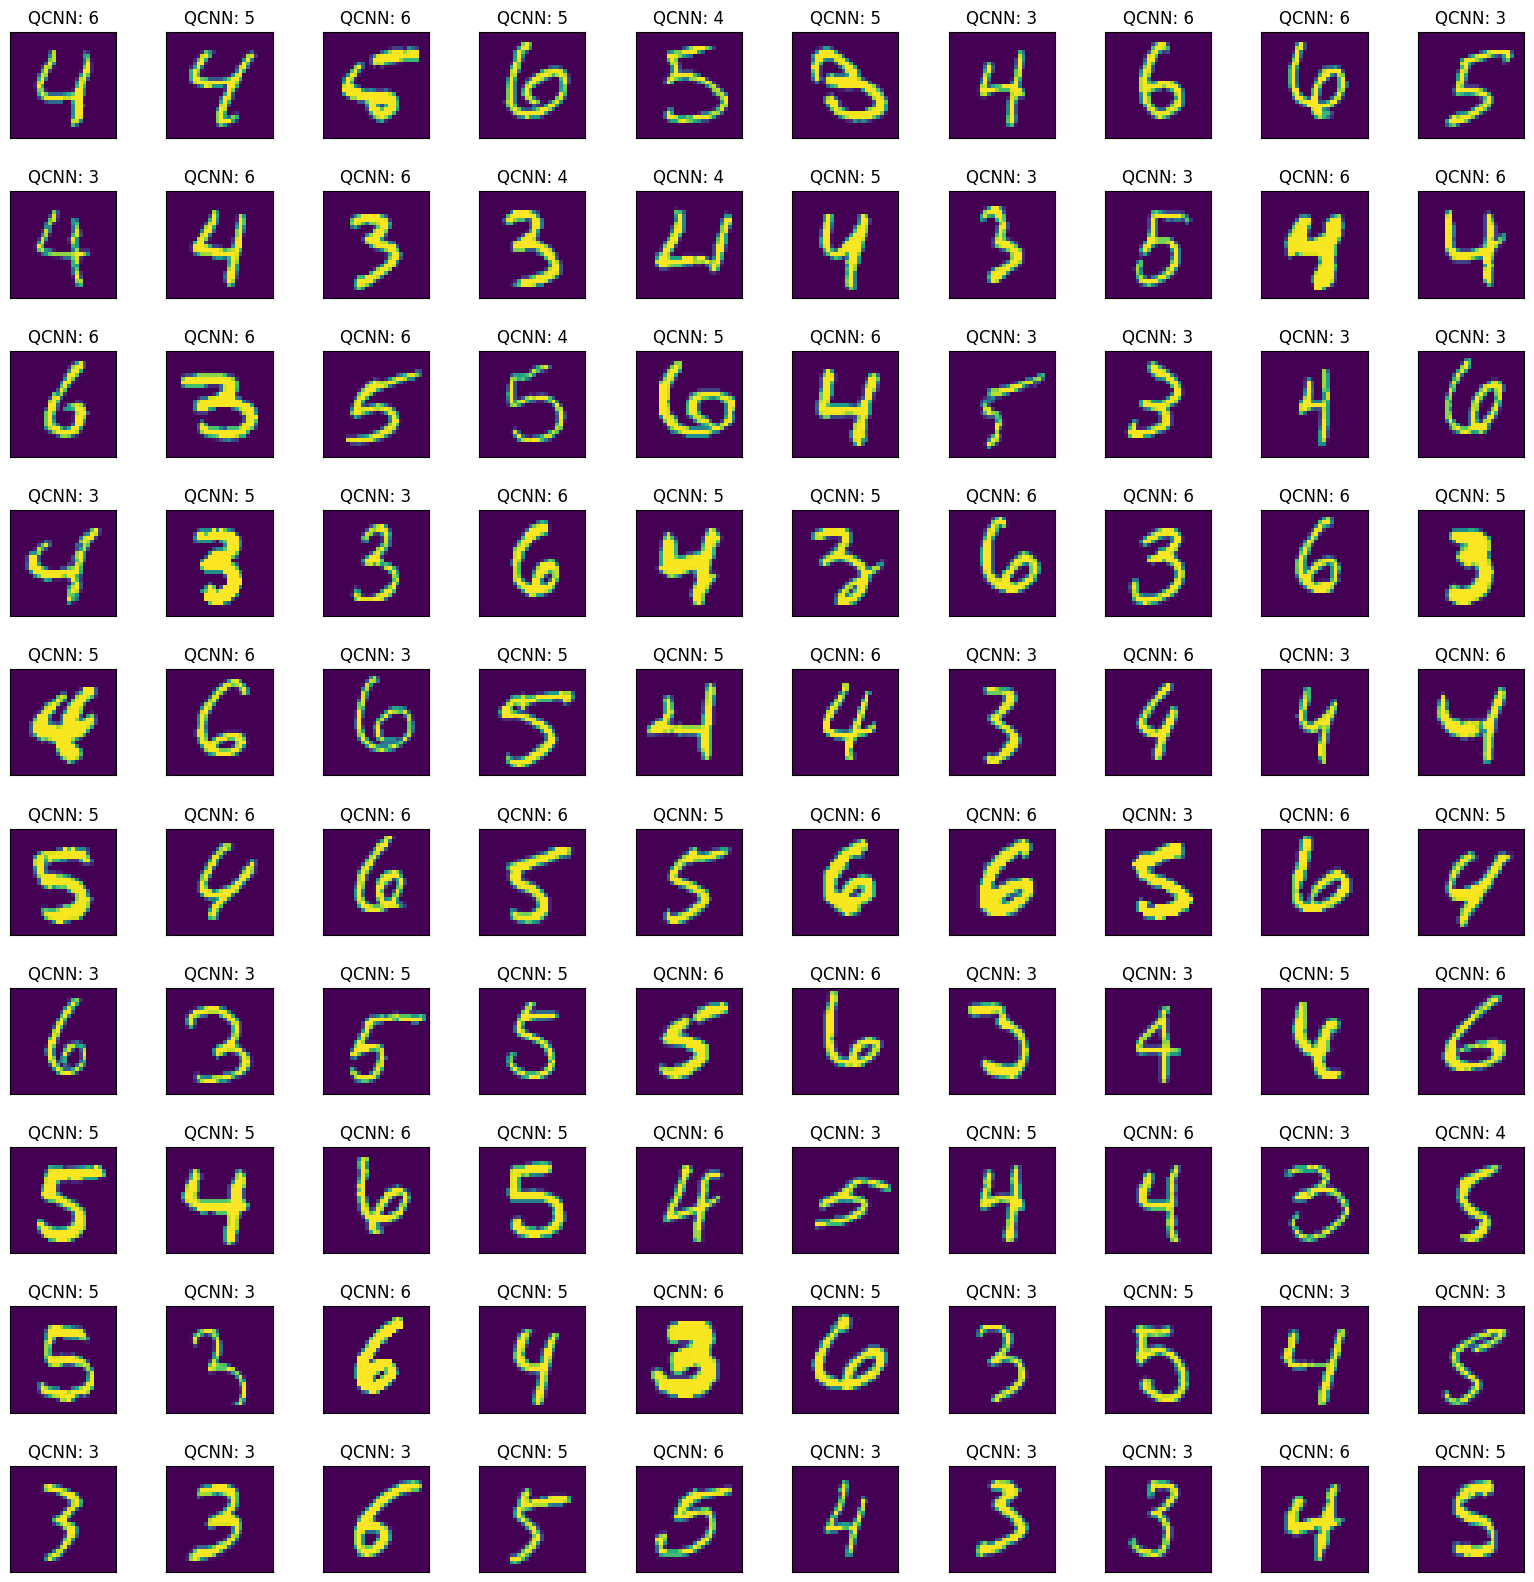

In [51]:
num_rows = 10
num_cols = 10
fig, ax = plt.subplots(num_rows, num_cols, figsize=(20, 20),
                       subplot_kw={"xticks": [], "yticks": []})

for i in range(num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    
    if i < len(x_test) and i < len(output1):
      ax[row, col].imshow(x_test[i].reshape(28, 28), aspect="equal")

      if torch.argmax(output1[i]) == 0:
          ax[row, col].set_title("QCNN: 3")
      elif torch.argmax(output1[i]) == 1:
          ax[row, col].set_title("QCNN: 4")
      elif torch.argmax(output1[i]) == 2:
          ax[row, col].set_title("QCNN: 5")
      elif torch.argmax(output1[i]) == 3:
          ax[row, col].set_title("QCNN: 6")
    else:
        ax[row, col].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.5)
plt.show()

In [52]:
print(result)

( message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 11.57565975189209
       x: [ 2.400e-01  7.322e-01 ...  8.951e-01  4.714e-01]
    nfev: 607
   maxcv: 0.0, ['Iteration: 1; Accuracy: 28.846153846153843%; Loss: 12.012578010559082', 'Iteration: 2; Accuracy: 28.846153846153843%; Loss: 12.012578010559082', 'Iteration: 3; Accuracy: 28.846153846153843%; Loss: 12.012578010559082', 'Iteration: 4; Accuracy: 28.846153846153843%; Loss: 12.012578010559082', 'Iteration: 5; Accuracy: 23.076923076923077%; Loss: 12.00673770904541', 'Iteration: 6; Accuracy: 27.884615384615387%; Loss: 12.025541305541992', 'Iteration: 7; Accuracy: 23.076923076923077%; Loss: 12.023637771606445', 'Iteration: 8; Accuracy: 29.807692307692307%; Loss: 11.961709022521973', 'Iteration: 9; Accuracy: 24.03846153846154%; Loss: 12.039372444152832', 'Iteration: 10; Accuracy: 17.307692307692307%; Loss: 12.065215110778809', 'Iteration: 11; Accuracy: 20.192307692307693%; Loss: 12.158997535705566', 'It

In [53]:
# Iteration Value Display Error (Skips back to 3)
result[1]

['Iteration: 1; Accuracy: 28.846153846153843%; Loss: 12.012578010559082',
 'Iteration: 2; Accuracy: 28.846153846153843%; Loss: 12.012578010559082',
 'Iteration: 3; Accuracy: 28.846153846153843%; Loss: 12.012578010559082',
 'Iteration: 4; Accuracy: 28.846153846153843%; Loss: 12.012578010559082',
 'Iteration: 5; Accuracy: 23.076923076923077%; Loss: 12.00673770904541',
 'Iteration: 6; Accuracy: 27.884615384615387%; Loss: 12.025541305541992',
 'Iteration: 7; Accuracy: 23.076923076923077%; Loss: 12.023637771606445',
 'Iteration: 8; Accuracy: 29.807692307692307%; Loss: 11.961709022521973',
 'Iteration: 9; Accuracy: 24.03846153846154%; Loss: 12.039372444152832',
 'Iteration: 10; Accuracy: 17.307692307692307%; Loss: 12.065215110778809',
 'Iteration: 11; Accuracy: 20.192307692307693%; Loss: 12.158997535705566',
 'Iteration: 12; Accuracy: 32.69230769230769%; Loss: 11.985200881958008',
 'Iteration: 13; Accuracy: 34.61538461538461%; Loss: 11.955270767211914',
 'Iteration: 14; Accuracy: 30.76923076